In [71]:
import os as os
import os.path as op
import zipfile
import uuid
import shutil
import xml.etree.ElementTree
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [106]:
qaaResultsDir = "d:\WorkFolder\AutoTestsResults\Chrome"

In [107]:
def getFilesFromDir(dirPath):
    onlyfiles = [op.join(dirPath, f) for f in os.listdir(dirPath) if op.isfile(op.join(dirPath, f)) and f.endswith(".zip")]
    return onlyfiles

In [108]:
def unpackFile(file, targetDir):
    with zipfile.ZipFile(file, 'r') as zip_ref:
        zip_ref.extractall(targetDir)

In [109]:
def getNewUuid():
    return uuid.uuid4().hex

In [110]:
def readTestResults(files):
    data = []
    
    for file in files:
        #print(file)
        tempDir = op.join(qaaResultsDir, getNewUuid())
        unpackFile(file, tempDir)
        testResultsFilePath = op.join(tempDir, "TestResult.xml")
        root = xml.etree.ElementTree.parse(testResultsFilePath).getroot()
        testSuite = root.find("test-suite")

        if not testSuite == None:
            testCount = int(testSuite.attrib["testcasecount"])
            duration = float(testSuite.attrib["duration"])
            passed = int(testSuite.attrib["passed"])
            failed = int(testSuite.attrib["failed"])
            startTimeTxt = testSuite.attrib["start-time"]
            startTime = dt.datetime.strptime(testSuite.attrib["start-time"], '%Y-%m-%d %H:%M:%SZ')
            data.append((testCount, duration, passed, failed, startTime, startTimeTxt))

        shutil.rmtree(tempDir)    
    
    return data

In [111]:
def prepareDataFrame(data):
    df = pd.DataFrame(data)
    df.columns = ['test_count', 'duration', 'tests_passed', 'tests_failed', 'start_time_txt', 'start_time']
    dfs = df.sort_values(by=['start_time_txt'])
    dfsf = dfs[dfs['tests_failed'] != dfs['test_count']]
    return dfsf

In [116]:
def createTrendGraph(plotData, graphFilePath):
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)

    plt.plot(plotData['start_time_txt'], plotData['test_count'], label='Tests count', color = 'black')
    plt.plot(plotData['start_time_txt'], plotData['tests_passed'], label='Tests passed (IE)', color = 'green')
    plt.plot(plotData['start_time_txt'], plotData['tests_failed'], label='Tests failed (IE)', color = 'red')
    plt.legend()
    plt.show()
    fig.savefig(graphFilePath, dpi=100)

In [122]:
def getDataFromPickle(dataFile):
    if op.isfile(dataFile):
        return pd.read_pickle(dataFile)
    
    return None

In [128]:
def processDataAndCreateGraph(dataFolder, graphFilePath, pickledDataFile):
    plotData = getDataFromPickle(pickledDataFile)
    if plotData is None:
        zipFiles = getFilesFromDir(dataFolder)
        data = readTestResults(zipFiles)
        plotData = prepareDataFrame(data)
        plotData.to_pickle(pickledDataFile)
        
    createTrendGraph(plotData, graphFilePath)    

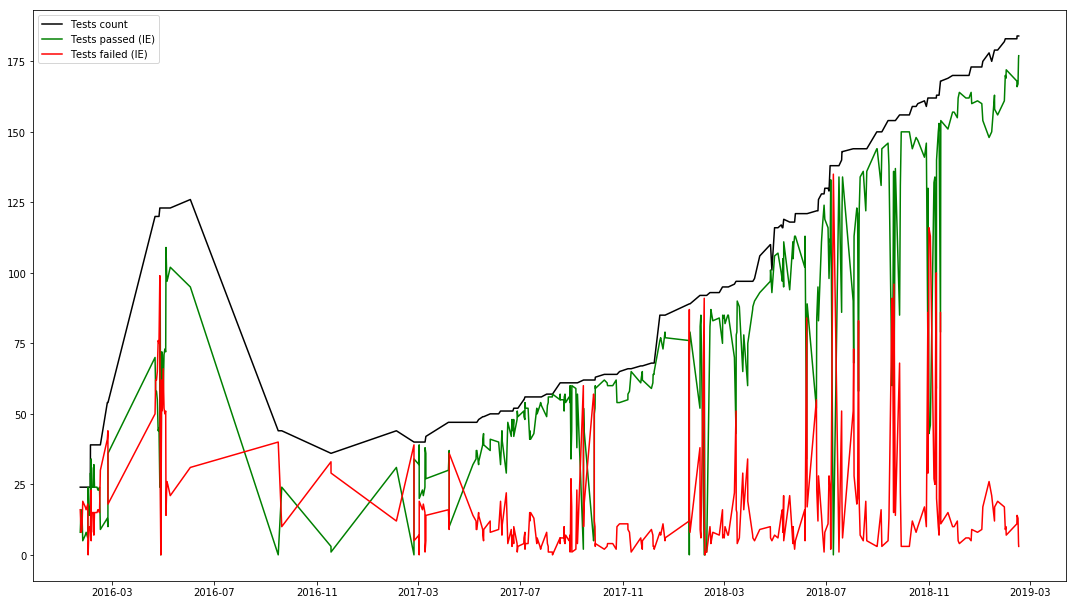

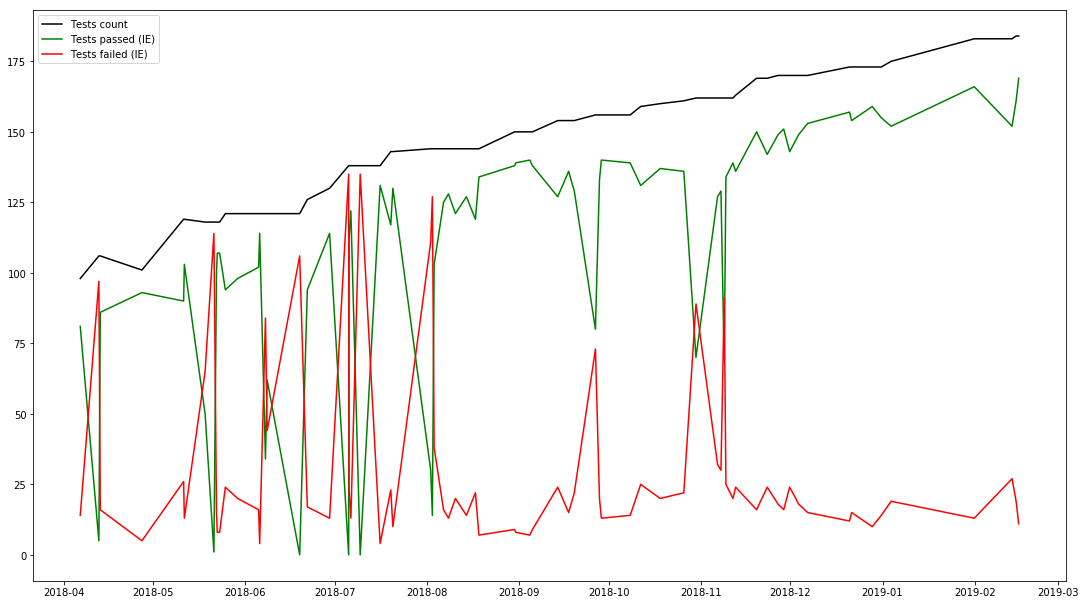

In [131]:
processDataAndCreateGraph("d:\WorkFolder\AutoTestsResults\Chrome", "d:/testTrendChrome.png", "d:\WorkFolder\AutoTestsResults\Chrome\chrome.pickle")
processDataAndCreateGraph("d:\WorkFolder\AutoTestsResults\IE", "d:/testTrendIE.png", "d:\WorkFolder\AutoTestsResults\IE\ie.pickle")